# Compile of everything

## 1. Import Libraries


In [152]:
import pandas as pd

# Load data
df_train = pd.read_csv("kdd_train.csv")
df_test = pd.read_csv("kdd_test.csv")

# Inspect
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print(df_train.head())


Train shape: (125973, 42)
Test shape: (22544, 42)
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                   0.170                   0.030   
1                   0.000                   0.600   
2  

## Encode Categorical Features

In [153]:
from sklearn.preprocessing import LabelEncoder

# Combine for consistent encoding
combined = pd.concat([df_train, df_test], axis=0)

# Encode all object (categorical) columns
label_encoders = {}
for col in combined.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    le.fit(combined[col])
    label_encoders[col] = le
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])


## Encode Labels

In [154]:
target_col = df_train.columns[-1]  # Assuming last column is the label
target_encoder = LabelEncoder()

# Fit on train labels only
df_train[target_col] = target_encoder.fit_transform(df_train[target_col])

# Only keep test samples with known labels
df_test = df_test[df_test[target_col].isin(target_encoder.classes_)].copy()

# Transform test labels
df_test[target_col] = target_encoder.transform(df_test[target_col])


## Feature Scaling

In [155]:
from sklearn.preprocessing import StandardScaler

# Split X and y
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col]

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Train Random Forest Classifier

In [156]:
from sklearn.ensemble import RandomForestClassifier

# Train
model = RandomForestClassifier(n_estimators=150, max_depth=25, random_state=42)
model.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=25, n_estimators=150, random_state=42)

## Evaluate Model Performance



In [160]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# Predict
y_pred = model.predict(X_test_scaled)

# Metrics
print("Accuracy:        ", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):   ", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro): ", f1_score(y_test, y_pred, average='macro'))

# Classification Report
unique_labels = sorted(np.unique(y_test))
target_names_used = target_le.inverse_transform(unique_labels)

print("\nClassification Report:\n", classification_report(
    y_test, y_pred,
    labels=unique_labels,
    target_names=target_names_used,
    zero_division=0
))


Accuracy:         0.9629871950649593
Precision (macro): 0.934218620306138
Recall (macro):    0.7034230199467841
F1 Score (macro):  0.7347073360685219

Classification Report:
                  precision    recall  f1-score   support

           back       1.00      1.00      1.00       227
buffer_overflow       1.00      0.41      0.58        17
      ftp_write       1.00      0.50      0.67         2
   guess_passwd       1.00      0.02      0.04       411
           imap       1.00      1.00      1.00         2
        ipsweep       1.00      1.00      1.00       479
           land       1.00      0.50      0.67         2
     loadmodule       1.00      0.75      0.86         4
       multihop       1.00      0.11      0.20         9
        neptune       1.00      1.00      1.00      6654
           nmap       1.00      0.99      1.00       206
         normal       0.94      0.99      0.97     11245
           perl       0.00      0.00      0.00         1
            phf       1.00

## Plot Confusion Matrix

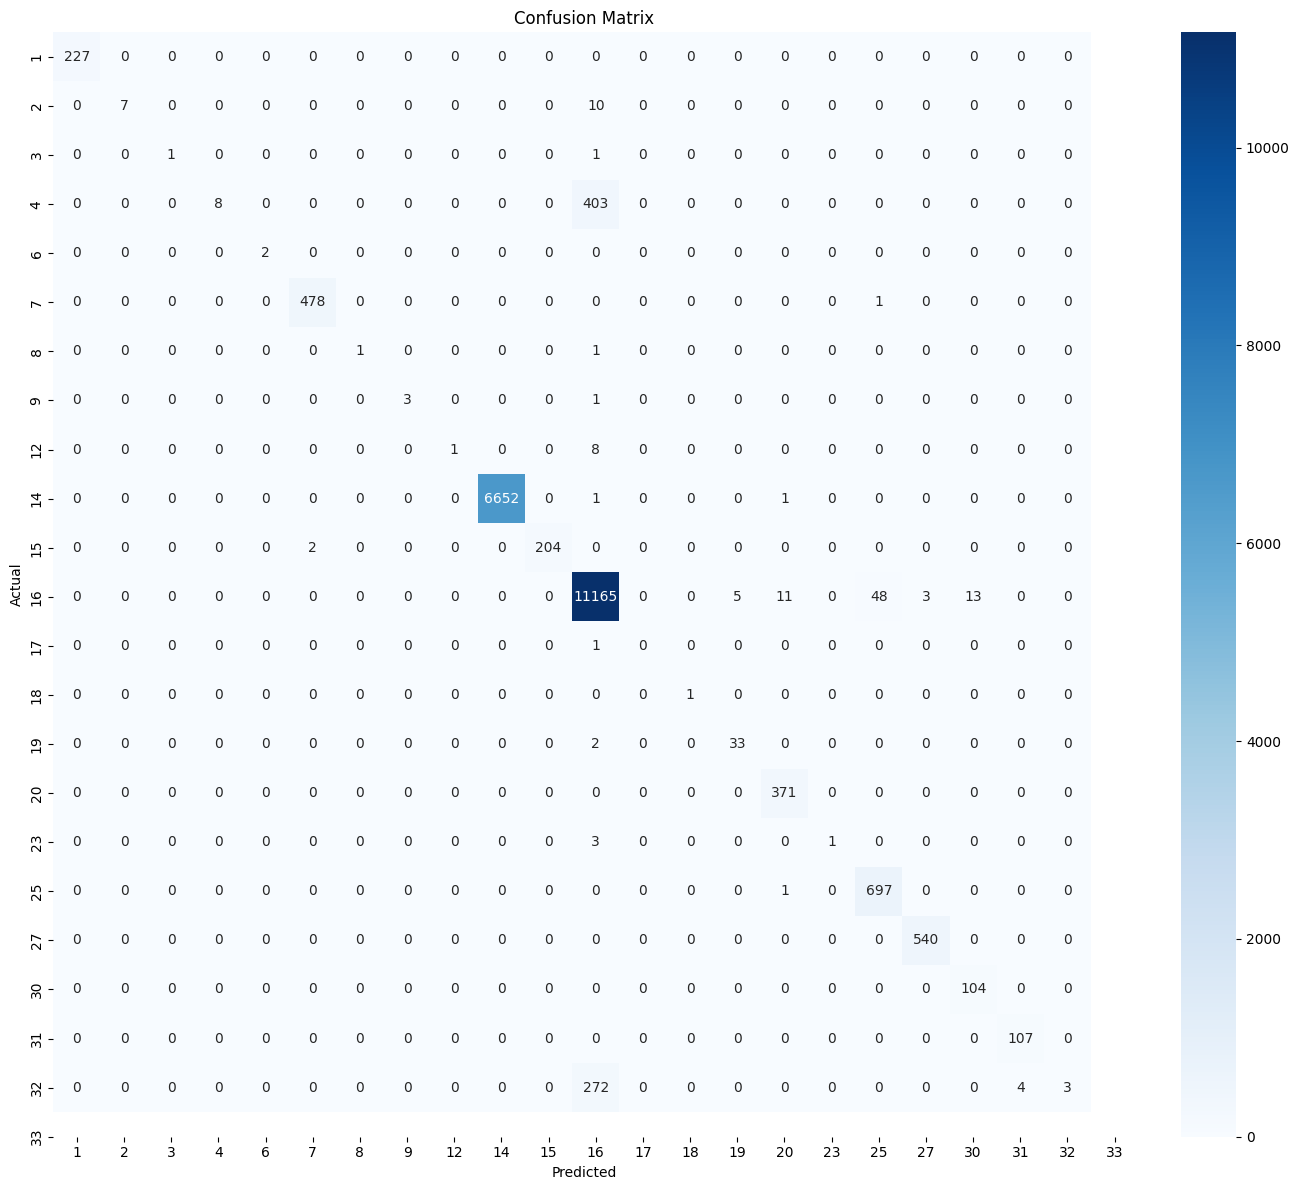

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
